In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Clean stuff

In [2]:
!rm -rf /kaggle/working/*

# Import libraries and Customize Parameters

In [3]:
# Pip install method (recommended)
%pip install ultralytics
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 15.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importing the required libraries
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
import matplotlib.image as mpimg
import seaborn as sns
import torch

sns.set_style('darkgrid')

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
# Check if PyTorch is using the GPU
print("Is CUDA available? ", torch.cuda.is_available())
print("Device name: ", torch.cuda.get_device_name(0))
# Set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device is on: {device}')

Is CUDA available?  True
Device name:  Tesla P100-PCIE-16GB
Device is on: cuda


# Visualize simple images with annotations

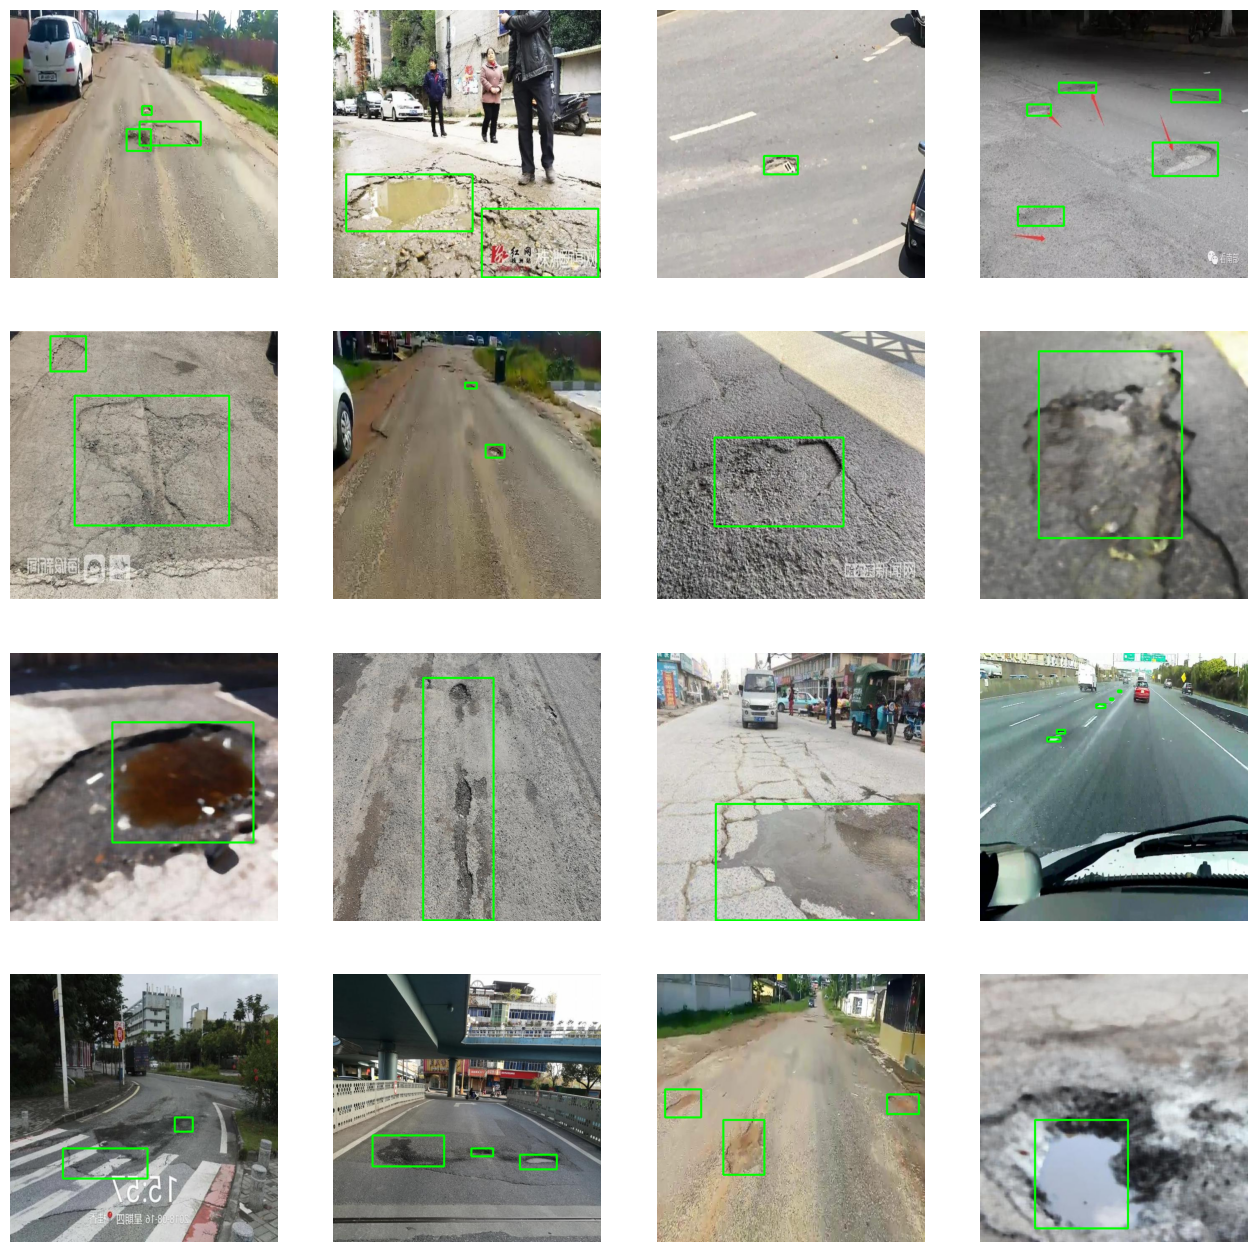

In [6]:
# Define the paths to the images and labels directories
train_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/images"
train_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels"

test_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"
test_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images"

val_images = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/images"
val_labels = "/kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)


    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

# Show image metadata

In [7]:
# Load an image using OpenCV
image = cv2.imread("/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images/0004_jpg.rf.f92ab952cd8544f887caf35fcccbcd10.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

The image has dimensions 640x640 and 3 channels.


# Model Training

In [8]:
# Loading a pretrained model
model = YOLO('yolo11n.pt')

# free up GPU memory
torch.cuda.empty_cache()

# Training the model
model.train(data = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml',
            epochs = 250,
            imgsz = (height, width, channels),
            seed = 42,
            batch = 8,
            workers = 4,
            optimizer = "Adam")

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.7MB/s]


Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/pothole-reduced-dataset/reduced_dataset/data.yaml, epochs=250, time=None, patience=100, batch=8, imgsz=(640, 640, 3), save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]
2024-11-23 18:05:37,705	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-23 18:05:38,176	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/train/labels... 2400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:07<00:00, 325.93it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:01<00:00, 286.74it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      1.46G      2.138      2.473      2.003         49        640: 100%|██████████| 300/300 [00:46<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]

                   all        300        936      0.095      0.106     0.0363     0.0109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      1.44G       2.17      2.413      2.081         38        640: 100%|██████████| 300/300 [00:42<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.47it/s]

                   all        300        936       0.29      0.207      0.155     0.0557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      1.44G      2.094      2.269      2.025         46        640: 100%|██████████| 300/300 [00:42<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]

                   all        300        936      0.283      0.233      0.186     0.0648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      1.44G      2.037      2.192       1.96         44        640: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.04it/s]


                   all        300        936      0.345      0.312      0.233     0.0907

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      1.44G      1.996      2.083      1.925         37        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


                   all        300        936      0.456      0.403      0.381      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      1.44G      1.952      2.014        1.9         30        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.49it/s]


                   all        300        936      0.486      0.405      0.396      0.174

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      1.44G      1.938      1.987      1.883         39        640: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


                   all        300        936      0.369       0.27      0.253      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      1.44G       1.92      1.922      1.858         40        640: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.47it/s]

                   all        300        936      0.556      0.429      0.435      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      1.44G      1.892      1.922      1.841         33        640: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.64it/s]

                   all        300        936      0.552      0.376      0.407      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      1.44G      1.889      1.906      1.849         27        640: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.63it/s]


                   all        300        936      0.543      0.409      0.417      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      1.44G      1.885      1.918      1.833         39        640: 100%|██████████| 300/300 [00:41<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.45it/s]

                   all        300        936       0.56      0.421      0.457      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      1.46G      1.868      1.879      1.822         18        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.59it/s]

                   all        300        936       0.55      0.468      0.467      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      1.44G       1.84      1.828       1.81         27        640: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]

                   all        300        936      0.567      0.428      0.453       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      1.44G      1.847      1.817      1.793         44        640: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.65it/s]

                   all        300        936      0.579      0.451      0.477      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      1.44G      1.848      1.836      1.823         48        640: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.95it/s]

                   all        300        936      0.571      0.439      0.483      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      1.44G      1.823      1.801      1.787         43        640: 100%|██████████| 300/300 [00:41<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.78it/s]


                   all        300        936      0.636      0.447      0.507       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      1.46G      1.801      1.774      1.775         43        640: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.54it/s]


                   all        300        936      0.542      0.326      0.347      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      1.44G      1.847      1.778      1.801         54        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.75it/s]

                   all        300        936      0.601      0.458      0.499      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      1.44G      1.804      1.746      1.778         38        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.93it/s]


                   all        300        936      0.581      0.468      0.513      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      1.44G      1.812      1.746      1.769         76        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.80it/s]

                   all        300        936      0.604      0.454      0.488      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      1.46G      1.801      1.724      1.751         39        640: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]


                   all        300        936      0.526      0.479      0.454      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      1.46G      1.789      1.734      1.756         27        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.00it/s]


                   all        300        936      0.609      0.437      0.494      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      1.44G       1.79      1.725       1.77         30        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.43it/s]


                   all        300        936      0.555       0.47      0.487      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      1.44G      1.805      1.738      1.764         52        640: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.79it/s]


                   all        300        936      0.556       0.46      0.463      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      1.45G      1.786      1.721      1.761         50        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.79it/s]


                   all        300        936      0.619      0.504      0.534      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      1.46G      1.774      1.701      1.759         38        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.73it/s]

                   all        300        936      0.577      0.469      0.494      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      1.44G       1.77      1.683      1.755         29        640: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.80it/s]


                   all        300        936      0.608      0.427      0.474      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      1.44G      1.763      1.662      1.747         31        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


                   all        300        936      0.562      0.503      0.519      0.248

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      1.44G      1.767      1.674      1.756         21        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


                   all        300        936      0.611      0.482      0.527      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      1.44G      1.758      1.652      1.725         33        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]

                   all        300        936      0.647      0.489      0.555      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      1.44G      1.774      1.684      1.749         30        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.82it/s]


                   all        300        936      0.623      0.492      0.529      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      1.44G      1.769      1.669      1.748         39        640: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]


                   all        300        936      0.574      0.512      0.532      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      1.44G      1.723       1.62      1.716         49        640: 100%|██████████| 300/300 [00:42<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.76it/s]

                   all        300        936      0.624      0.522      0.565      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      1.46G      1.747      1.617      1.715         47        640: 100%|██████████| 300/300 [00:41<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.75it/s]


                   all        300        936      0.599      0.468      0.502       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      1.44G      1.737      1.594      1.723         48        640: 100%|██████████| 300/300 [00:42<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.84it/s]

                   all        300        936      0.582      0.489      0.506      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      1.44G      1.702      1.584      1.707         34        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


                   all        300        936      0.659      0.531      0.585        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      1.44G      1.731      1.624      1.719         46        640: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.65it/s]


                   all        300        936      0.631      0.534      0.563      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      1.45G      1.725      1.589      1.714         34        640: 100%|██████████| 300/300 [00:42<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.91it/s]


                   all        300        936        0.6      0.522      0.553      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      1.44G      1.726      1.613      1.726         40        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.83it/s]

                   all        300        936      0.599      0.518      0.557      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      1.44G      1.711      1.583      1.697         66        640: 100%|██████████| 300/300 [00:41<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.48it/s]

                   all        300        936      0.638      0.551      0.574      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      1.44G      1.712      1.582      1.711         31        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]

                   all        300        936      0.678      0.476       0.55      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      1.45G      1.729      1.591      1.727         43        640: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


                   all        300        936      0.648      0.516      0.552      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      1.44G      1.721      1.603      1.713         35        640: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]

                   all        300        936      0.672       0.47      0.533      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      1.44G      1.699      1.583      1.703         29        640: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.68it/s]

                   all        300        936      0.637      0.511      0.552      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      1.44G      1.695      1.549      1.693         32        640: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.88it/s]


                   all        300        936      0.662      0.501      0.576      0.303

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      1.44G      1.699      1.562       1.69         18        640: 100%|██████████| 300/300 [00:41<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.15it/s]

                   all        300        936      0.556      0.522      0.528      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      1.44G      1.716      1.589      1.705         41        640: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.66it/s]


                   all        300        936      0.643      0.553      0.601      0.305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      1.44G      1.698      1.527       1.69         56        640: 100%|██████████| 300/300 [00:41<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.68it/s]

                   all        300        936      0.638      0.546      0.589      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      1.44G      1.707      1.564      1.702         45        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.92it/s]


                   all        300        936      0.648      0.542      0.592      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      1.46G      1.672      1.517      1.666         38        640: 100%|██████████| 300/300 [00:41<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.50it/s]


                   all        300        936       0.65       0.52      0.586      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      1.44G      1.686      1.511      1.677         22        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.19it/s]


                   all        300        936      0.578      0.526      0.534      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      1.44G      1.686      1.531      1.694         43        640: 100%|██████████| 300/300 [00:41<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.98it/s]


                   all        300        936      0.686      0.531      0.597      0.309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      1.44G      1.677      1.481      1.667         41        640: 100%|██████████| 300/300 [00:41<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.05it/s]


                   all        300        936      0.641      0.551      0.601      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      1.44G      1.657      1.513      1.663         30        640: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]

                   all        300        936      0.638      0.527      0.563      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      1.44G      1.665      1.509      1.656         36        640: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.78it/s]

                   all        300        936      0.661      0.536      0.597       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      1.44G      1.648      1.487      1.648         27        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 10.22it/s]


                   all        300        936      0.685       0.56      0.613      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      1.44G      1.668      1.494      1.673         38        640: 100%|██████████| 300/300 [00:41<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.11it/s]


                   all        300        936      0.681       0.52      0.601      0.323

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      1.44G      1.674      1.501      1.661         20        640: 100%|██████████| 300/300 [00:41<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.29it/s]

                   all        300        936      0.665      0.565      0.614      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      1.44G      1.641      1.442      1.635         54        640: 100%|██████████| 300/300 [00:41<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.85it/s]


                   all        300        936      0.691      0.549        0.6      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      1.44G      1.664      1.491      1.667         35        640: 100%|██████████| 300/300 [00:41<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.47it/s]

                   all        300        936      0.643      0.557      0.575      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      1.44G      1.656      1.459      1.658         37        640: 100%|██████████| 300/300 [00:41<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.60it/s]

                   all        300        936      0.674      0.556       0.61      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      1.44G      1.638      1.476      1.644         22        640: 100%|██████████| 300/300 [00:42<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.93it/s]


                   all        300        936      0.701       0.55      0.614      0.329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      1.44G      1.663       1.47      1.665         53        640: 100%|██████████| 300/300 [00:43<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.23it/s]

                   all        300        936      0.645      0.522      0.581      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      1.44G      1.641      1.505      1.653         48        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]

                   all        300        936      0.709      0.515      0.588      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      1.44G      1.632      1.468      1.655         31        640: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.38it/s]

                   all        300        936      0.665      0.562       0.61      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      1.44G      1.628      1.461       1.64         41        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.48it/s]


                   all        300        936      0.669      0.559      0.618      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      1.44G      1.634      1.428      1.635         57        640: 100%|██████████| 300/300 [00:43<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


                   all        300        936      0.658      0.588      0.616      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      1.44G      1.617      1.415       1.63         32        640: 100%|██████████| 300/300 [00:43<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.50it/s]

                   all        300        936      0.732      0.573      0.646      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      1.46G      1.616      1.444      1.635         37        640: 100%|██████████| 300/300 [00:43<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.95it/s]

                   all        300        936      0.687      0.586      0.628      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      1.44G      1.632      1.439      1.631         47        640: 100%|██████████| 300/300 [00:43<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


                   all        300        936      0.706      0.597       0.65      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      1.44G       1.62      1.427      1.628         23        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00,  9.52it/s]


                   all        300        936      0.663      0.573      0.624      0.347

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      1.44G      1.626      1.443      1.627         44        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]

                   all        300        936      0.683      0.584      0.637      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      1.44G      1.641      1.411      1.641         34        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.59it/s]

                   all        300        936      0.725      0.595       0.65      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      1.44G       1.62      1.403      1.639         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]

                   all        300        936      0.687       0.58      0.631      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      1.44G      1.646      1.452      1.637         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


                   all        300        936      0.684       0.59      0.635      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      1.44G      1.596      1.407      1.609         52        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.49it/s]

                   all        300        936      0.723      0.572       0.65      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      1.46G      1.607      1.419      1.623         38        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


                   all        300        936      0.695      0.566      0.642      0.357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      1.44G       1.61      1.402      1.633         22        640: 100%|██████████| 300/300 [00:44<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.25it/s]

                   all        300        936      0.669      0.585      0.628      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      1.44G       1.61      1.432       1.62         26        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.39it/s]


                   all        300        936      0.704      0.591      0.645      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      1.44G      1.605      1.393      1.629         44        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]

                   all        300        936      0.699        0.6      0.654      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      1.46G      1.629      1.437      1.638         48        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]


                   all        300        936      0.666      0.604       0.65      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      1.44G      1.582      1.368      1.594         53        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]

                   all        300        936       0.69       0.62      0.675      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      1.44G      1.601      1.387      1.605         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]

                   all        300        936       0.71      0.592      0.651       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      1.44G      1.599      1.382      1.616         39        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.45it/s]

                   all        300        936        0.7      0.593      0.655      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      1.46G       1.59      1.383        1.6         48        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.03it/s]


                   all        300        936      0.713      0.597      0.672      0.371

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      1.44G      1.588      1.384      1.613         16        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.40it/s]

                   all        300        936      0.718      0.605      0.656      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      1.44G      1.605      1.387      1.609         54        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.26it/s]

                   all        300        936      0.713      0.605      0.659      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      1.44G      1.594      1.361      1.607         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.88it/s]


                   all        300        936      0.717      0.601      0.659      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      1.44G      1.587       1.38      1.614         55        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]


                   all        300        936      0.695      0.571      0.641      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      1.44G      1.577      1.354      1.594         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]

                   all        300        936      0.718      0.597      0.662       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      1.44G      1.589       1.39      1.608         69        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


                   all        300        936      0.702       0.61      0.665      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      1.43G      1.575      1.358      1.598         36        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]

                   all        300        936       0.74      0.612      0.683      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      1.44G      1.572      1.365        1.6         38        640: 100%|██████████| 300/300 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.64it/s]

                   all        300        936      0.722      0.607      0.669      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      1.44G       1.57      1.369      1.598         47        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


                   all        300        936      0.779      0.599      0.681      0.383

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      1.44G      1.569      1.368       1.59         46        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


                   all        300        936       0.78      0.596      0.682      0.381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      1.44G      1.573      1.354      1.602         40        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


                   all        300        936       0.74      0.595      0.667      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      1.44G      1.573      1.336      1.595         51        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.16it/s]


                   all        300        936      0.785      0.585      0.687      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      1.44G       1.54      1.337      1.582         42        640: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


                   all        300        936      0.723      0.646      0.693      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      1.44G      1.555      1.315      1.575         40        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.97it/s]

                   all        300        936      0.715      0.609      0.677      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      1.44G      1.573      1.342      1.598         44        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


                   all        300        936      0.726      0.617      0.672      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      1.44G      1.568       1.34      1.589         41        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.40it/s]


                   all        300        936      0.766       0.62      0.694      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      1.45G      1.563      1.326      1.576         26        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.08it/s]

                   all        300        936       0.75      0.621      0.684      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      1.46G      1.539      1.307      1.564         40        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.10it/s]

                   all        300        936      0.778      0.618      0.706      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      1.44G      1.549      1.293      1.569         28        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]

                   all        300        936      0.754      0.607      0.688      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      1.44G      1.555      1.308      1.566         38        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]

                   all        300        936      0.719      0.645      0.687      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      1.44G      1.555      1.322      1.569         47        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


                   all        300        936      0.681      0.634      0.681       0.39

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      1.44G      1.536      1.308      1.558         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.80it/s]

                   all        300        936      0.746      0.621      0.682      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      1.44G      1.543      1.296      1.563         42        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.83it/s]

                   all        300        936      0.742      0.619      0.691        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      1.44G      1.541      1.307      1.578         47        640: 100%|██████████| 300/300 [00:45<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


                   all        300        936      0.739      0.624      0.685      0.397

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      1.44G      1.518      1.289      1.554         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.96it/s]


                   all        300        936      0.718      0.644      0.698      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      1.44G      1.535      1.287      1.562         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]

                   all        300        936      0.755      0.595      0.694      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      1.44G      1.531      1.288      1.559         32        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.44it/s]

                   all        300        936      0.721      0.628      0.691      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      1.44G      1.546      1.305      1.559         36        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.01it/s]

                   all        300        936      0.762        0.6      0.696      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      1.44G      1.531      1.303      1.563         50        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]

                   all        300        936      0.789      0.624      0.715      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      1.46G       1.52      1.279      1.548         31        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.21it/s]

                   all        300        936        0.8      0.623      0.729      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      1.44G      1.527      1.283       1.56         36        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.15it/s]

                   all        300        936      0.814      0.575      0.704      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      1.44G      1.506      1.277      1.537         40        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]


                   all        300        936      0.791      0.603      0.705      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      1.44G      1.504      1.267      1.543         42        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.35it/s]


                   all        300        936      0.748      0.639      0.719      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      1.44G      1.528      1.265      1.554         45        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]


                   all        300        936      0.756      0.638      0.716      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      1.44G      1.522      1.262      1.548         28        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.40it/s]

                   all        300        936      0.756      0.628        0.7      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      1.44G      1.503      1.255      1.541         31        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.13it/s]


                   all        300        936      0.791      0.597      0.708      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      1.44G      1.503      1.246      1.535         21        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]

                   all        300        936      0.723      0.645        0.7      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      1.44G      1.497      1.253      1.542         38        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]

                   all        300        936       0.76      0.644      0.711      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      1.44G      1.503      1.255      1.544         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]

                   all        300        936      0.792      0.626      0.725      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      1.44G      1.485      1.225      1.516         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]

                   all        300        936       0.74      0.649      0.715      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      1.44G      1.499      1.236      1.524         39        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.47it/s]


                   all        300        936      0.746      0.636      0.716      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      1.44G      1.488      1.248      1.525         30        640: 100%|██████████| 300/300 [00:43<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]


                   all        300        936      0.736      0.672      0.732      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      1.44G      1.481      1.217      1.523         27        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.68it/s]

                   all        300        936       0.74      0.667      0.732      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      1.44G      1.467      1.206      1.515         42        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]

                   all        300        936      0.774      0.644      0.738      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      1.44G      1.487      1.225      1.532         40        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.53it/s]

                   all        300        936      0.768      0.674      0.735      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      1.44G      1.489      1.222      1.513         58        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.15it/s]


                   all        300        936      0.736      0.642      0.722      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      1.45G      1.471        1.2      1.496         31        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.28it/s]

                   all        300        936      0.794      0.634      0.731      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      1.45G      1.473      1.199      1.505         37        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.99it/s]

                   all        300        936      0.776      0.657      0.741      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      1.44G      1.467      1.194      1.514         23        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.15it/s]

                   all        300        936       0.79       0.64       0.73      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      1.44G      1.465      1.206      1.506         49        640: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


                   all        300        936      0.781      0.637      0.726      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      1.44G      1.471      1.195      1.508         29        640: 100%|██████████| 300/300 [00:45<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]

                   all        300        936      0.765      0.642      0.729      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      1.44G      1.469      1.201      1.503         27        640: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.34it/s]

                   all        300        936      0.766      0.647      0.724      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      1.46G      1.463      1.181      1.503         59        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.78it/s]

                   all        300        936      0.744      0.677      0.734      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      1.44G      1.448      1.187      1.493         40        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]

                   all        300        936      0.792      0.669      0.744      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      1.44G      1.461      1.213      1.501         47        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.94it/s]

                   all        300        936      0.787       0.64      0.734      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      1.44G       1.44      1.195      1.494         34        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]

                   all        300        936      0.776      0.656      0.741      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      1.46G      1.466      1.215      1.506         32        640: 100%|██████████| 300/300 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]

                   all        300        936      0.801      0.636      0.741       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      1.44G      1.447      1.171       1.48         26        640: 100%|██████████| 300/300 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.08it/s]

                   all        300        936      0.769      0.668       0.74      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      1.44G      1.437      1.173      1.489         44        640: 100%|██████████| 300/300 [00:43<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]

                   all        300        936      0.811      0.641      0.736      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      1.44G      1.458        1.2      1.507         43        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.39it/s]

                   all        300        936      0.792      0.658      0.734      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      1.44G       1.45      1.181      1.494         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]

                   all        300        936      0.812      0.659      0.754      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      1.44G      1.426      1.178      1.475         36        640: 100%|██████████| 300/300 [00:44<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


                   all        300        936      0.797      0.675      0.746      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      1.44G      1.424      1.161       1.47         39        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]


                   all        300        936        0.8      0.656      0.747       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      1.44G      1.432      1.158      1.476         20        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.73it/s]

                   all        300        936       0.82      0.655      0.744      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      1.44G      1.418      1.138      1.468         45        640: 100%|██████████| 300/300 [00:44<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]

                   all        300        936      0.831      0.646      0.747      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      1.44G      1.431      1.153      1.481         43        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.39it/s]

                   all        300        936      0.784      0.672      0.739      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      1.45G      1.428      1.143       1.47         30        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]


                   all        300        936      0.827      0.654      0.745      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      1.44G      1.412      1.145      1.468         27        640: 100%|██████████| 300/300 [00:44<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.27it/s]

                   all        300        936       0.79      0.667      0.747      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      1.45G      1.428      1.136      1.474         49        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


                   all        300        936      0.805      0.676      0.754      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      1.44G      1.432      1.158      1.465         43        640: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.46it/s]


                   all        300        936      0.798      0.688      0.761      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      1.45G      1.425      1.157      1.457         43        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.31it/s]

                   all        300        936        0.8      0.668      0.749      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      1.44G      1.405      1.136      1.447         60        640: 100%|██████████| 300/300 [00:43<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]

                   all        300        936      0.814      0.673      0.761      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      1.44G      1.407      1.136      1.459         68        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


                   all        300        936      0.798      0.686      0.753      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      1.44G        1.4      1.118      1.454         34        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]


                   all        300        936      0.815      0.687      0.762      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      1.45G      1.399      1.127      1.452         42        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


                   all        300        936      0.799      0.688      0.759       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      1.44G      1.397      1.124       1.45         25        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.09it/s]

                   all        300        936      0.797      0.681       0.76      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      1.44G      1.402      1.116      1.456         32        640: 100%|██████████| 300/300 [00:45<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]

                   all        300        936      0.818      0.689      0.768       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      1.44G      1.394      1.112      1.442         36        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]

                   all        300        936       0.82      0.683      0.771      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      1.44G      1.398      1.113       1.46         44        640: 100%|██████████| 300/300 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.12it/s]

                   all        300        936      0.843      0.677      0.771      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      1.44G      1.386      1.102      1.439         45        640: 100%|██████████| 300/300 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


                   all        300        936      0.836      0.697      0.775      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      1.44G      1.393      1.091       1.44         60        640: 100%|██████████| 300/300 [00:43<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.30it/s]


                   all        300        936       0.83      0.674      0.767       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      1.44G      1.384      1.093      1.442         44        640: 100%|██████████| 300/300 [00:45<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.04it/s]


                   all        300        936      0.831      0.689       0.77      0.473

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      1.44G      1.374      1.084      1.428         21        640: 100%|██████████| 300/300 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.82it/s]

                   all        300        936      0.797      0.696      0.768      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      1.44G      1.394      1.119      1.447         48        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.60it/s]

                   all        300        936      0.821      0.689      0.774      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      1.47G      1.384      1.101      1.439         18        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.91it/s]

                   all        300        936      0.789      0.704      0.776      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      1.44G      1.385        1.1      1.444         36        640: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.15it/s]

                   all        300        936      0.843      0.681      0.772       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      1.46G      1.377      1.124      1.435         39        640: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.13it/s]

                   all        300        936      0.828      0.674      0.771      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      1.46G      1.378      1.081      1.423         22        640: 100%|██████████| 300/300 [00:44<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.43it/s]


                   all        300        936      0.826      0.678      0.771      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      1.44G      1.368      1.083      1.429         33        640: 100%|██████████| 300/300 [00:45<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.77it/s]

                   all        300        936      0.818       0.69      0.771      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      1.44G      1.369      1.075      1.425         42        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.05it/s]

                   all        300        936      0.831      0.681      0.778      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      1.44G      1.358      1.063      1.421         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.29it/s]

                   all        300        936      0.823      0.688      0.774      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      1.44G      1.365      1.075      1.421         36        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


                   all        300        936      0.834      0.701      0.779      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      1.44G       1.35      1.065      1.411         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.71it/s]

                   all        300        936       0.84      0.683      0.778      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      1.44G      1.357      1.075      1.416         34        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]


                   all        300        936      0.829      0.688      0.784      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      1.44G      1.337      1.045      1.399         39        640: 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.28it/s]


                   all        300        936      0.827      0.697      0.774      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      1.44G      1.343      1.054       1.41         40        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.24it/s]

                   all        300        936      0.835      0.696      0.782      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      1.44G      1.341      1.063      1.408         32        640: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]

                   all        300        936      0.825      0.707      0.781      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      1.44G      1.359      1.075      1.425         25        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.49it/s]


                   all        300        936      0.823      0.683      0.781      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      1.44G      1.348      1.071      1.421         22        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.70it/s]


                   all        300        936      0.815      0.702      0.779      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      1.44G      1.348      1.054      1.404         50        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.32it/s]

                   all        300        936      0.827      0.694      0.782      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      1.44G      1.349      1.051      1.404         23        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.98it/s]


                   all        300        936      0.824      0.713      0.788       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      1.44G      1.325      1.037      1.397         34        640: 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]

                   all        300        936      0.819      0.706      0.786      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      1.44G      1.351      1.043      1.405         41        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.27it/s]

                   all        300        936      0.807      0.702      0.779      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      1.44G      1.334      1.051      1.405         25        640: 100%|██████████| 300/300 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]


                   all        300        936      0.814      0.705      0.781      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      1.44G      1.333      1.022      1.387         41        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


                   all        300        936      0.816      0.711      0.787      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      1.44G      1.331      1.047      1.393         21        640: 100%|██████████| 300/300 [00:44<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.44it/s]


                   all        300        936      0.807      0.708      0.785      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      1.44G      1.332      1.025      1.391         26        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]

                   all        300        936      0.812      0.715      0.782      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      1.44G      1.314      1.019      1.392         28        640: 100%|██████████| 300/300 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.76it/s]


                   all        300        936      0.824      0.703      0.781      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      1.45G      1.341      1.045      1.403         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]

                   all        300        936      0.843      0.694      0.785      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      1.44G      1.311      1.013      1.384         38        640: 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.78it/s]

                   all        300        936      0.814      0.708      0.786      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      1.44G      1.301      1.012      1.386         37        640: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.19it/s]

                   all        300        936      0.827      0.698      0.786      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      1.44G      1.325      1.026      1.389         30        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.42it/s]


                   all        300        936      0.814      0.716      0.788      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      1.43G      1.309       1.02      1.379         22        640: 100%|██████████| 300/300 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.20it/s]


                   all        300        936      0.815      0.723      0.794      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      1.44G       1.32      1.032      1.388         28        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.94it/s]

                   all        300        936      0.814       0.72       0.79      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      1.44G      1.308      1.016      1.377         31        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]

                   all        300        936      0.843       0.69      0.788      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      1.44G      1.296      1.011       1.38         35        640: 100%|██████████| 300/300 [00:45<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]

                   all        300        936      0.839       0.69       0.79      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      1.44G      1.294      1.002      1.363         48        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.48it/s]

                   all        300        936      0.845      0.707      0.794      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      1.44G      1.285     0.9855      1.365         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.48it/s]

                   all        300        936      0.824      0.718      0.796        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      1.44G      1.305      1.022      1.387         20        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]


                   all        300        936      0.828      0.706      0.792      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      1.46G      1.274     0.9863      1.355         55        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]

                   all        300        936      0.814      0.715      0.788      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      1.44G      1.301     0.9931      1.368         51        640: 100%|██████████| 300/300 [00:44<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.36it/s]


                   all        300        936      0.842      0.699       0.79      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      1.44G      1.292     0.9935      1.365         36        640: 100%|██████████| 300/300 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.72it/s]

                   all        300        936      0.844      0.706      0.794      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      1.44G      1.273     0.9868       1.36         33        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.14it/s]

                   all        300        936      0.838      0.709      0.795      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      1.44G      1.272     0.9715      1.348         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.18it/s]


                   all        300        936       0.83      0.698       0.79        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      1.44G      1.272     0.9658      1.346         28        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.37it/s]


                   all        300        936      0.826      0.702      0.789        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      1.44G      1.287     0.9752      1.362         29        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.06it/s]

                   all        300        936      0.863      0.679      0.795      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      1.46G      1.265     0.9765      1.343         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]


                   all        300        936      0.824      0.702      0.792      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      1.44G      1.251      0.955      1.339         33        640: 100%|██████████| 300/300 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.41it/s]


                   all        300        936      0.815      0.714      0.792      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      1.44G      1.253     0.9523      1.338         50        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.14it/s]

                   all        300        936      0.828      0.707      0.793      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      1.44G      1.262     0.9695      1.342         19        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.22it/s]


                   all        300        936      0.838      0.698      0.796      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      1.44G      1.256     0.9699      1.346         39        640: 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.33it/s]


                   all        300        936      0.842      0.688      0.791      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      1.44G      1.254     0.9585      1.344         37        640: 100%|██████████| 300/300 [00:44<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.94it/s]

                   all        300        936      0.819      0.708      0.791      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      1.44G      1.239     0.9397      1.327         45        640: 100%|██████████| 300/300 [00:45<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.24it/s]

                   all        300        936      0.815      0.714      0.794      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      1.44G      1.254     0.9648      1.339         31        640: 100%|██████████| 300/300 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]

                   all        300        936      0.825      0.713      0.796      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      1.44G      1.245      0.959      1.334         39        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.11it/s]

                   all        300        936      0.829      0.716        0.8      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      1.44G      1.234     0.9355      1.328         41        640: 100%|██████████| 300/300 [00:45<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.85it/s]

                   all        300        936      0.808      0.735      0.804       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      1.46G      1.235     0.9424      1.319         30        640: 100%|██████████| 300/300 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.26it/s]

                   all        300        936      0.828      0.719      0.799      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      1.44G      1.226     0.9358      1.327         49        640: 100%|██████████| 300/300 [00:44<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.13it/s]

                   all        300        936      0.831      0.715      0.795      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      1.43G      1.229     0.9212      1.323         51        640: 100%|██████████| 300/300 [00:45<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.81it/s]

                   all        300        936      0.862      0.695      0.797       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      1.44G      1.227     0.9353      1.319         25        640: 100%|██████████| 300/300 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.80it/s]

                   all        300        936       0.84      0.707      0.799       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      1.44G      1.213     0.9155      1.313         23        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.83it/s]

                   all        300        936      0.853      0.702      0.801      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      1.44G      1.235     0.9311      1.323         16        640: 100%|██████████| 300/300 [00:45<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.17it/s]

                   all        300        936      0.825      0.721      0.803      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      1.44G      1.201      0.905      1.305         37        640: 100%|██████████| 300/300 [00:45<00:00,  6.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.06it/s]

                   all        300        936      0.823      0.726      0.801      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250      1.44G      1.229     0.9204      1.326         25        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.14it/s]

                   all        300        936       0.84      0.718        0.8      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      1.44G      1.218     0.9217      1.316         25        640: 100%|██████████| 300/300 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.93it/s]

                   all        300        936      0.843       0.71      0.801       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250      1.44G      1.213     0.9161      1.306         51        640: 100%|██████████| 300/300 [00:45<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.10it/s]


                   all        300        936      0.843      0.721      0.803      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      1.44G      1.205     0.9063      1.307         41        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.21it/s]

                   all        300        936      0.835      0.726      0.805      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      1.44G       1.23     0.9189      1.313         54        640: 100%|██████████| 300/300 [00:45<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]

                   all        300        936      0.836      0.723      0.806      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      1.44G      1.204     0.8921      1.293         27        640: 100%|██████████| 300/300 [00:45<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.02it/s]

                   all        300        936      0.818      0.741      0.804      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      1.44G      1.191     0.8896      1.298         35        640: 100%|██████████| 300/300 [00:44<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.89it/s]

                   all        300        936      0.813      0.743      0.803      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      1.44G      1.205     0.9013      1.293         33        640: 100%|██████████| 300/300 [00:45<00:00,  6.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.83it/s]

                   all        300        936      0.817      0.737      0.805      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      1.44G      1.191     0.8876       1.29         56        640: 100%|██████████| 300/300 [00:45<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  7.94it/s]

                   all        300        936      0.823      0.735      0.807      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      1.45G      1.179     0.8915      1.292         44        640: 100%|██████████| 300/300 [00:44<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


                   all        300        936      0.849      0.714      0.806      0.514

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      1.44G      1.199      0.892      1.295         37        640: 100%|██████████| 300/300 [00:45<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.23it/s]

                   all        300        936       0.84       0.72      0.803      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      1.44G      1.183     0.8821       1.29         29        640: 100%|██████████| 300/300 [00:45<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.05it/s]

                   all        300        936      0.853      0.704      0.804      0.515


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      1.44G      1.177      0.821      1.289         29        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.82it/s]

                   all        300        936      0.864      0.706      0.807      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      1.44G      1.161      0.799      1.283         18        640: 100%|██████████| 300/300 [00:45<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.00it/s]

                   all        300        936       0.87        0.7      0.805      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250      1.44G      1.151     0.7879      1.271         32        640: 100%|██████████| 300/300 [00:43<00:00,  6.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.20it/s]

                   all        300        936      0.868      0.705      0.807      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      1.44G      1.124     0.7708      1.263         51        640: 100%|██████████| 300/300 [00:44<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.07it/s]


                   all        300        936      0.861      0.705      0.808      0.516

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250      1.44G      1.133     0.7714      1.266         18        640: 100%|██████████| 300/300 [00:44<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.25it/s]

                   all        300        936      0.858      0.715      0.808      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      1.44G      1.127     0.7558      1.259         26        640: 100%|██████████| 300/300 [00:43<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.03it/s]

                   all        300        936      0.858       0.71      0.807      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250      1.44G      1.114     0.7615      1.254         24        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


                   all        300        936      0.854      0.712      0.808      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      1.44G      1.122      0.757      1.258         14        640: 100%|██████████| 300/300 [00:44<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.81it/s]


                   all        300        936      0.837      0.717      0.808      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      1.44G      1.116      0.746       1.26         23        640: 100%|██████████| 300/300 [00:43<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.95it/s]


                   all        300        936      0.819      0.743      0.808       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      1.44G      1.116     0.7459      1.254         20        640: 100%|██████████| 300/300 [00:45<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  8.55it/s]

                   all        300        936      0.813      0.751      0.808      0.521



250 epochs completed in 3.264 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:02<00:00,  6.60it/s]


                   all        300        936      0.849      0.715      0.808      0.521
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f7e986c7b20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Model Performance

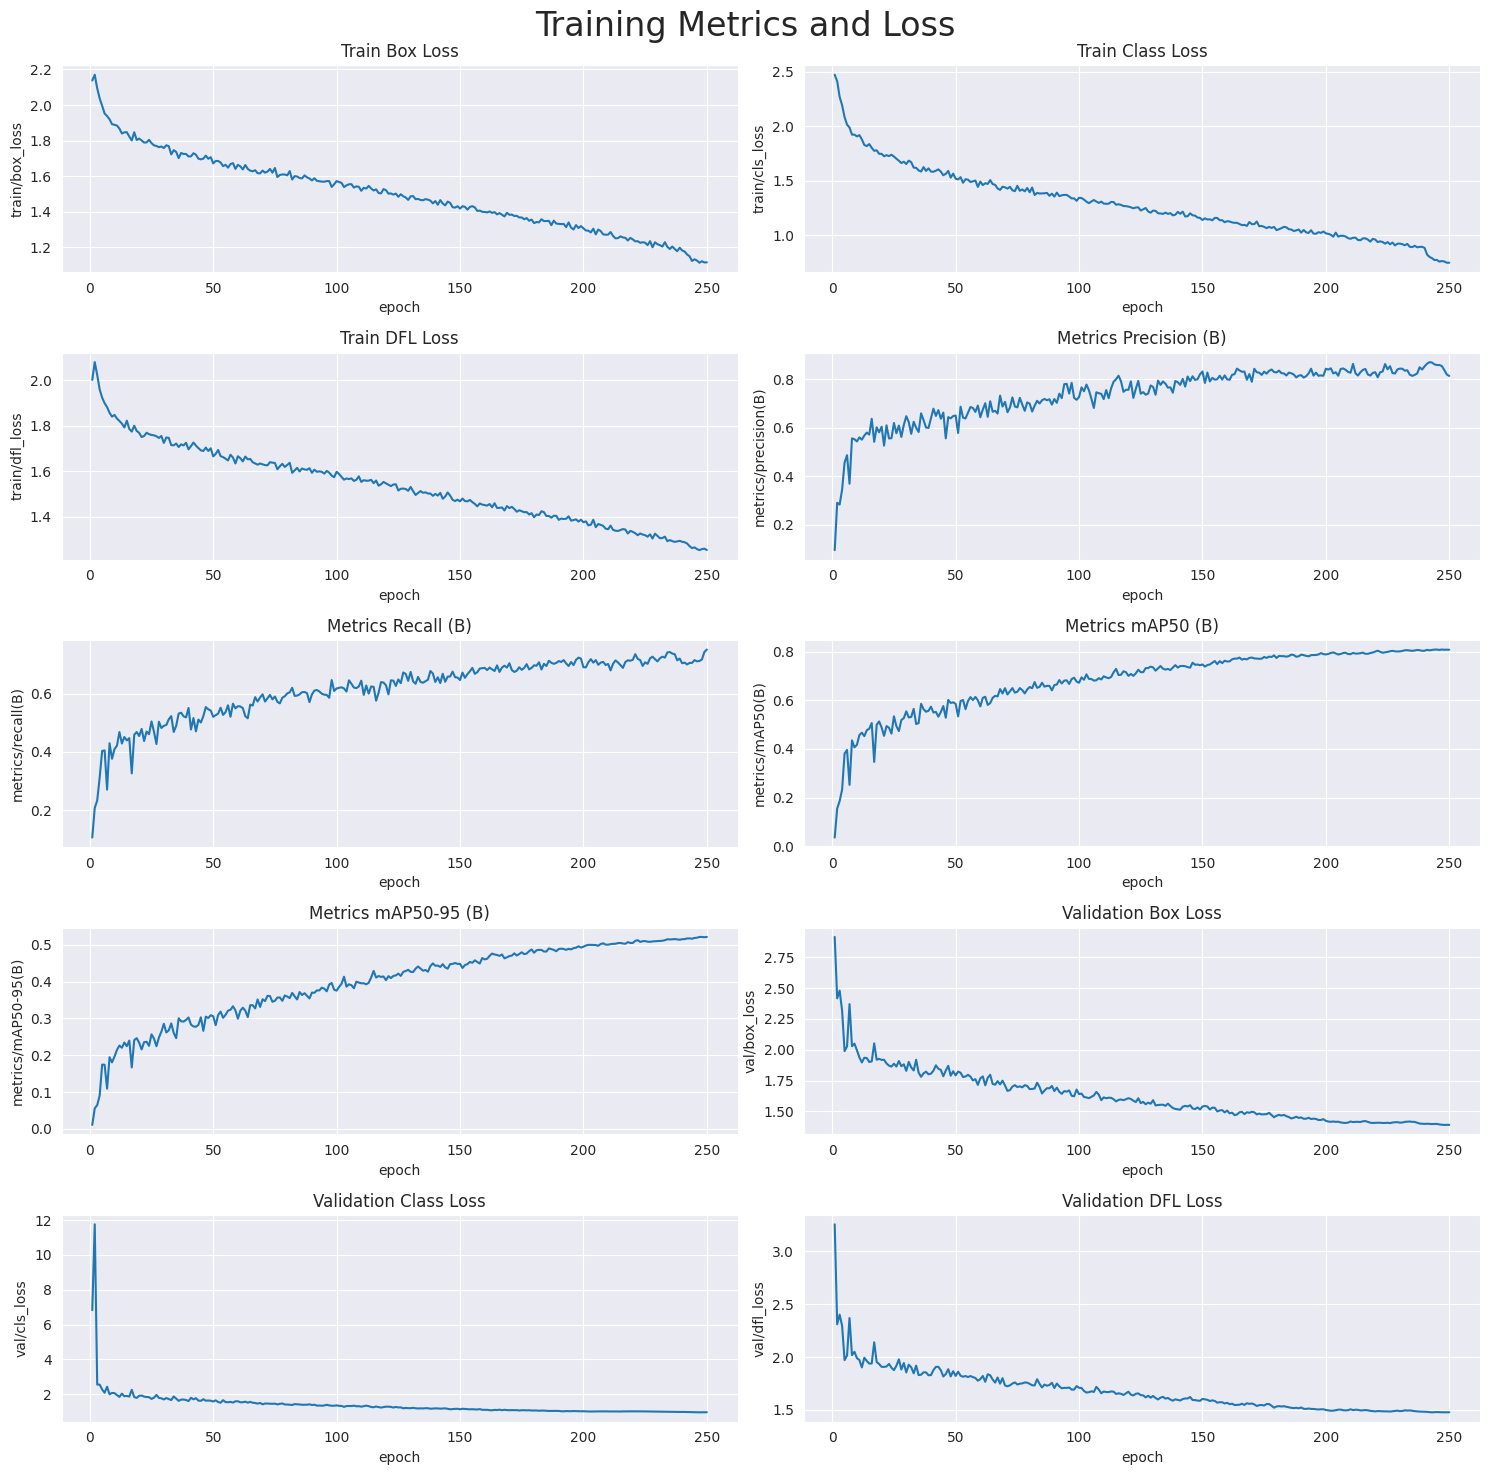

In [9]:
%matplotlib inline
# read in the results.csv file as a pandas dataframe
df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))

# plot the columns using seaborn
sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle('Training Metrics and Loss', fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.8)

# adjust spacing between subplots
plt.tight_layout()

plt.show()

# Model Evaluation

In [10]:
%matplotlib inline
# Loading the best performing model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/pothole-reduced-dataset/reduced_dataset/test/labels... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:01<00:00, 252.30it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/pothole-reduced-dataset/reduced_dataset/test is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:03<00:00,  5.57it/s]


                   all        300        844      0.855      0.777      0.857      0.618
Speed: 0.3ms preprocess, 3.5ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val


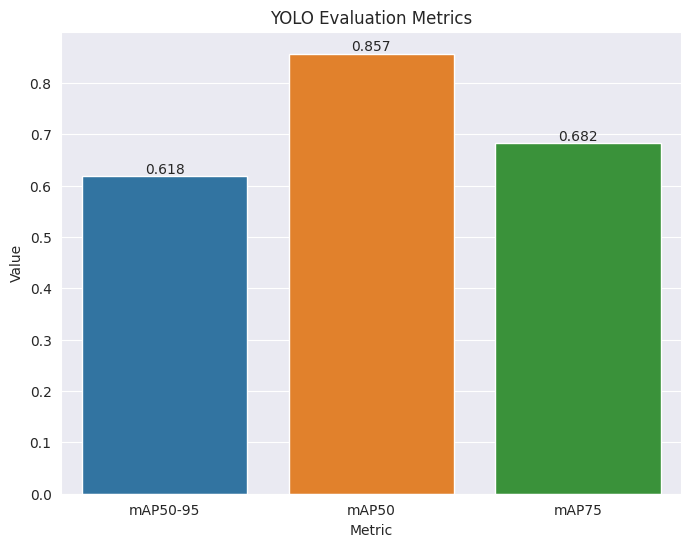

In [11]:
%matplotlib inline
# Create the barplot
ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])

# Set the title and axis labels
ax.set_title('YOLO Evaluation Metrics')
ax.set_xlabel('Metric')
ax.set_ylabel('Value')

# Set the figure size
fig = plt.gcf()
fig.set_size_inches(8, 6)

# Add the values on top of the bars
for p in ax.patches:
    ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
# Show the plot
plt.show()


## Confusion Matrix

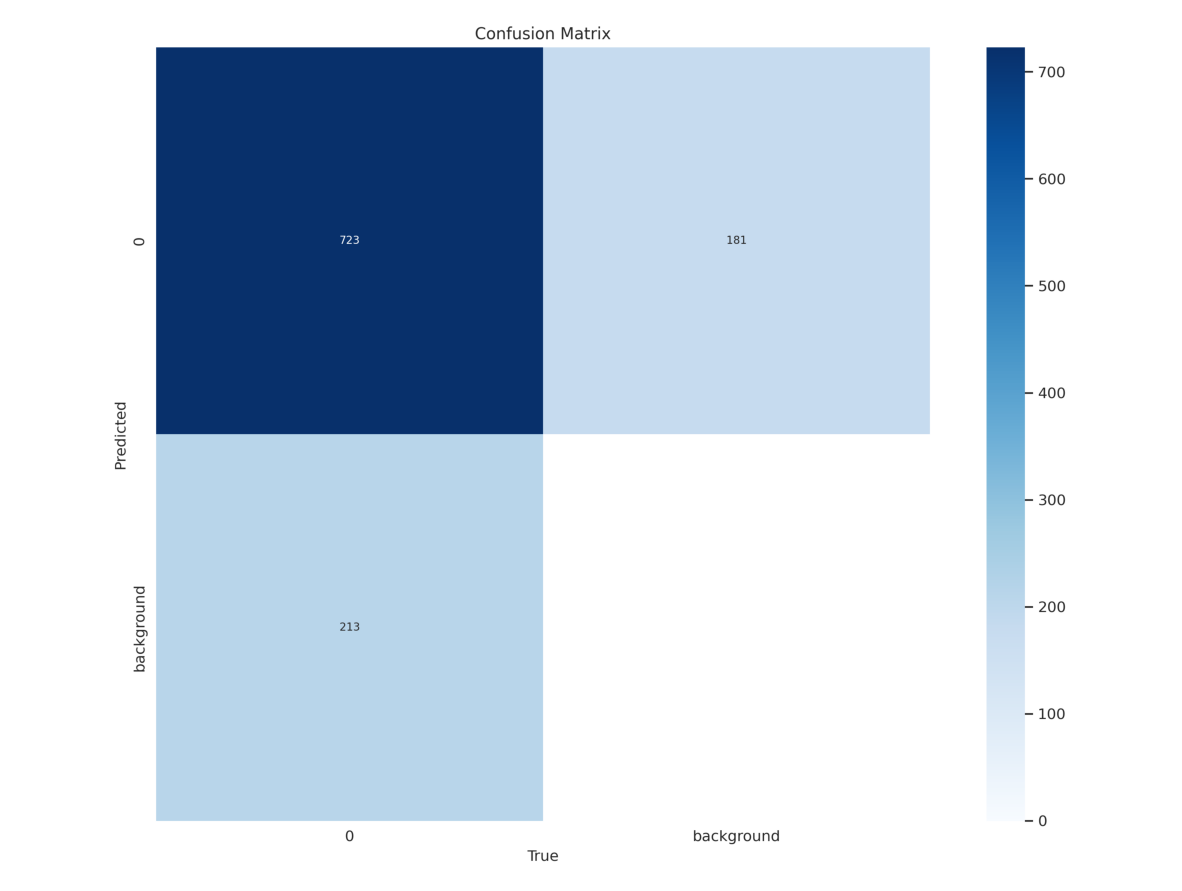

In [12]:
%matplotlib inline
# Reading the confusion matrix image file
img = mpimg.imread('/kaggle/working/runs/detect/train/confusion_matrix.png')

# Plotting the confusion matrix image
fig, ax = plt.subplots(figsize = (15, 15))

ax.imshow(img)
ax.axis('off');

# Making Predictions on Test Images

In [13]:
# Function to perform ship detections
def pothole_detect(img_path):
    
    # Read the image
    img = cv2.imread(img_path)

    # Pass the image through the detection model and get the result
    detect_result = model(img)

    # Plot the detections
    detect_img = detect_result[0].plot()
    
    # Convert the image to RGB format
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    
    return detect_img


0: 640x640 1 0, 11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 0s, 10.1ms
Speed: 2.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 9.9ms
Speed: 2.9ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 0s, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 0s, 10.2ms
Speed: 2.4ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 11 0s, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 0s, 9.3ms
Speed: 2

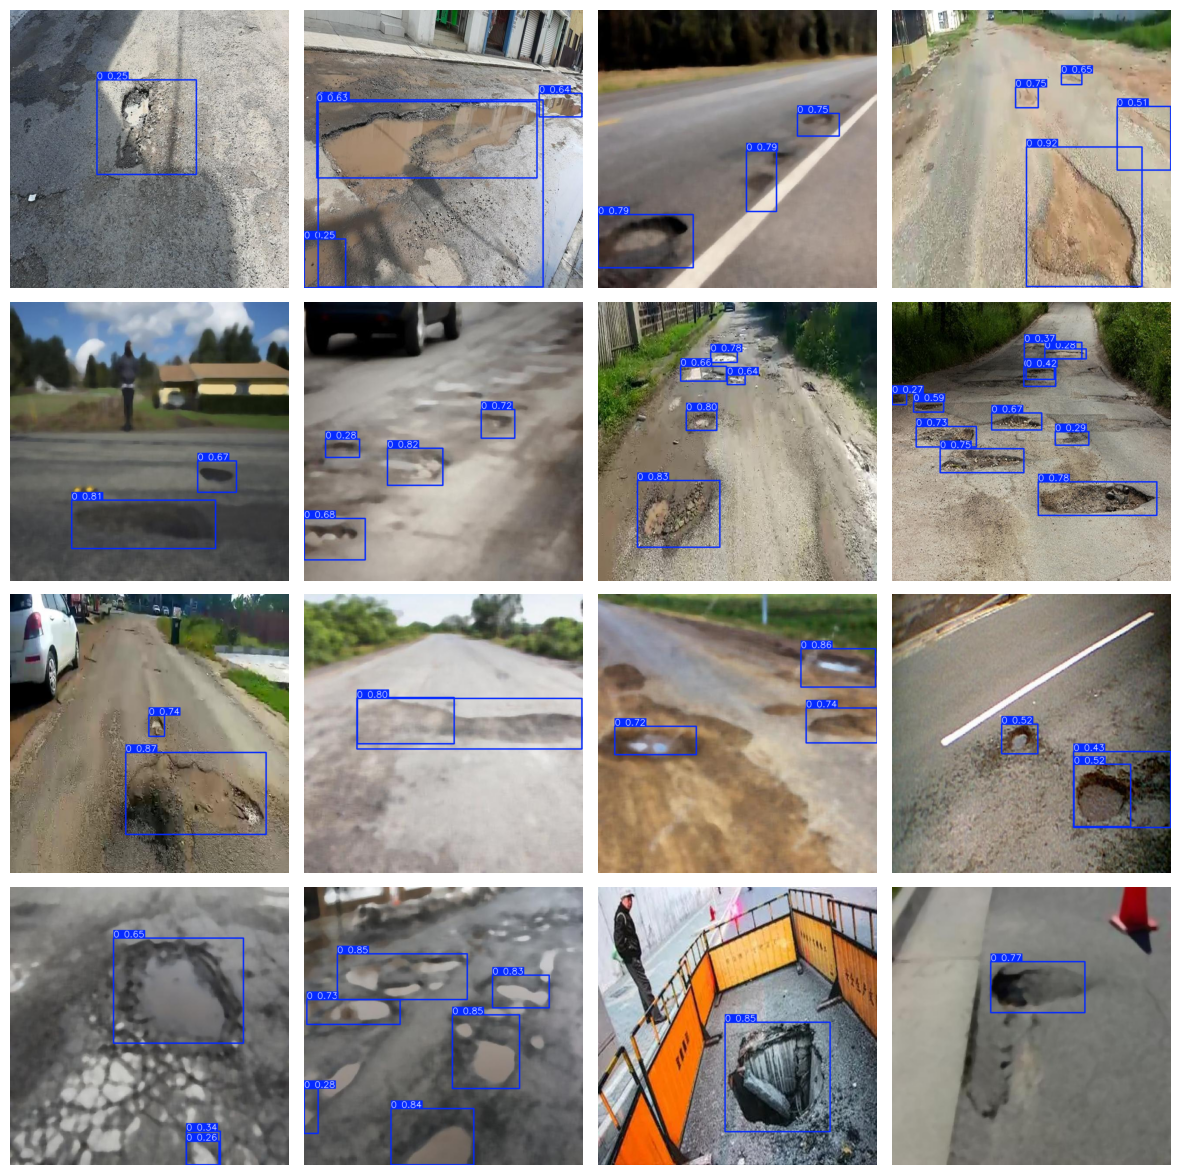

In [14]:
import random

# Define the directory where the custom images are stored
custom_image_dir = '/kaggle/input/pothole-reduced-dataset/reduced_dataset/test/images'

# Get the list of image files in the directory
image_files = os.listdir(custom_image_dir)

# Select 16 random images from the list
selected_images = random.sample(image_files, 16)

# Create a figure with subplots for each image
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))

# Iterate over the selected images and plot each one
for i, img_file in enumerate(selected_images):
    
    # Compute the row and column index of the current subplot
    row_idx = i // 4
    col_idx = i % 4
    
    # Load the current image and run object detection
    img_path = os.path.join(custom_image_dir, img_file)
    detect_img = pothole_detect(img_path)
    
    # Plot the current image on the appropriate subplot
    axes[row_idx, col_idx].imshow(detect_img)
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)

# Download train results and model

In [15]:
# zip the test results folder
!zip -r yolo_training_results.zip /kaggle/working/runs

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  adding: kaggle/working/runs/ (stored 0%)
  adding: kaggle/working/runs/detect/ (stored 0%)
  adding: kaggle/working/runs/detect/val/ (stored 0%)
  adding: kaggle/working/runs/detect/val/P_curve.png (deflated 21%)
  adding: kaggle/working/runs/detect/val/val_batch2_labels.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/val_batch1_pred.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/val/R_curve.png (deflated 17%)
  adding: kaggle/working/runs/detect/val/F1_curve.png (deflated 18%)
  adding: kaggle/working/runs/detect/val/val_batch0_labels.jpg (deflated 8%)
  adding: kaggle/working/runs/detect/val/val_batch0_pred.jpg (deflated 7%)
  adding: kaggle/working/runs/detect/val/val_batch1_labels.jpg (deflated 9%)
  adding: kaggle/working/runs/detect/val/PR_curve.png (deflated 20%)
  adding: kaggle/working/runs/detect/val/val_batch2_pred.jpg (deflated 6%)
  adding: kaggle/working/runs/detect/val/confusion_matrix.png (deflated 40%)
  adding: kaggle/working/runs/detect/val/confu

In [16]:
!mkdir /kaggle/output/
!mv yolo_training_results.zip /kaggle/output/